In [1]:
import os
import sys
import time
import gc 
import psutil
import json
from pathlib import Path

import uproot
import awkward as ak
import numpy as np

import vector
vector.register_awkward()

import dask
from dask.distributed import Client

print("All imports added")

All imports added


In [2]:
client = Client("tls://localhost:8786")
client

<Client: 'tls://192.168.161.139:8786' processes=1 threads=1, memory=2.89 GiB>

In [3]:
HOME_DIR = Path(os.environ.get("HOME", "/home/cms-jovyan"))
PROJECT_NAME = "H-to-WW-NanoAOD-analysis"

PROJECT_DIR = HOME_DIR / PROJECT_NAME
DATASETS_DIR = PROJECT_DIR / "Datasets"
DATA_DIR = DATASETS_DIR / "DATA"
MC_DIR = DATASETS_DIR / "MC_samples"
AUX_DIR = PROJECT_DIR / "Auxillary_files"

GOLDEN_JSON_PATH = AUX_DIR / "Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt"

RUN_PERIODS_2016 = {
    "Run2016G": {"run_min": 278820, "run_max": 280385},
    "Run2016H": {"run_min": 280919, "run_max": 284044}
}

print(f"HOME_DIR:         {HOME_DIR}")
print(f"PROJECT_DIR:     {PROJECT_DIR}")
print(f"DATA_DIR:        {DATA_DIR}")
print(f"MC_DIR:          {MC_DIR}")
print(f"AUX_DIR:         {AUX_DIR}")
print(f"GOLDEN_JSON:      {GOLDEN_JSON_PATH}")
print(f"JSON exists:     {GOLDEN_JSON_PATH.exists()}")


HOME_DIR:         /home/cms-jovyan
PROJECT_DIR:     /home/cms-jovyan/H-to-WW-NanoAOD-analysis
DATA_DIR:        /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets/DATA
MC_DIR:          /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets/MC_samples
AUX_DIR:         /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files
GOLDEN_JSON:      /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files/Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt
JSON exists:     True


In [29]:
SAMPLE_MAPPING = {
    'data' : "Data",
    'dytoll' : "DY_to_Tau_Tau",
}

def load_urls_from_files(filepath, max_files = None):
    urls = []

    if not os.path.exists(filepath):
        return urls

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line and line.startswith('root://'):
                urls.append(line)
                if max_files and len(urls) >= max_files:
                    break
    return urls

def load_all_files(data_dir, mc_dir, max_per_sample = None):

    files_dict = {}

    for directory in [data_dir, mc_dir]:
        if not os.path.exists(directory):
            continue

        for filename in os.listdir(directory):
            if not filename.endswith(".txt"):
                continue

            filepath = os.path.join(directory, filename)
            filename_lower = filename.lower().replace('.txt', '')

            label = None

            for pattern, sample_label in SAMPLE_MAPPING.items():
                if pattern in filename_lower:
                    label = sample_label
                    break

            if not label:
                print(f" unknown file: {filename}- skipping")
                continue

            urls = load_urls_from_files(filepath, max_per_sample)

            if urls: 
                if label in files_dict:
                    files_dict[label].extend(urls)
                else:
                    files_dict[label] =urls

    return files_dict

# files = load_all_files(DATA_DIR, MC_DIR, max_per_sample= 1)
files = load_all_files(DATA_DIR, MC_DIR)

print("\n" + "="*70)
print("FILES TO PROCESS")
print("="*70)
total = 0
for label, urls in files.items():
    print(f"{label:20s}: {len(urls):4d} files")
    total += len(urls)
print("_"*70)
print(f"{'TOTAL':20s}: {total:4d} files")
print("="*70)

 unknown file: VG.txt- skipping
 unknown file: Higgs.txt- skipping
 unknown file: WW.txt- skipping
 unknown file: Fakes.txt- skipping
 unknown file: VZ.txt- skipping
 unknown file: ggWW.txt- skipping
 unknown file: Top.txt- skipping

FILES TO PROCESS
Data                :   48 files
DY_to_Tau_Tau       :   61 files
______________________________________________________________________
TOTAL               :  109 files


In [30]:
def load_golden_json(json_input, run_periods=None):
    """
    Load golden JSON from either a file path (str) or a dict.
    """
    
    if isinstance(json_input, str):
        with open(json_input, 'r') as f:
            golden_json = json.load(f)
    elif isinstance(json_input, dict):
        golden_json = json_input
    else:
        raise TypeError(f"Expected str or dict, got {type(json_input)}")
    
    valid_lumis = {}
    for run_str, lumi_ranges in golden_json.items():
        run = int(run_str)
        
        # Filter by run periods 
        if run_periods is not None: 
            in_period = any(
                period['run_min'] <= run <= period['run_max']
                for period in run_periods.values()
            )
            if not in_period:
                continue
        
        valid_lumis[run] = [tuple(lr) for lr in lumi_ranges]
    
    return valid_lumis


def apply_json_mask(arrays, json_input, run_periods=None):

    valid_lumis = load_golden_json(json_input, run_periods)
    
    runs = ak.to_numpy(arrays.run)
    lumis = ak.to_numpy(arrays.luminosityBlock)
    
    mask = np. zeros(len(runs), dtype=bool)
    
    for run, lumi_ranges in valid_lumis.items():
        run_mask = (runs == run)
        
        if not np.any(run_mask):
            continue
        
        # Check lumi sections 
        run_lumis = lumis[run_mask]
        run_lumi_mask = np.zeros(len(run_lumis), dtype=bool)
        
        for lumi_start, lumi_end in lumi_ranges: 
            run_lumi_mask |= (run_lumis >= lumi_start) & (run_lumis <= lumi_end)
        
        mask[run_mask] = run_lumi_mask
    
    return ak.Array(mask)

In [31]:
Batch_size = 1_250_000

def load_events(file_url, batch_size=1_250_000, timeout=600, max_retries=3, retry_wait=10, is_data=False):
    columns = [
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        "PuppiMET_pt", "PuppiMET_phi",
        
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",

        "HLT_Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ",
        "HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ"
    ]

    if is_data:
        columns.extend(["run", "luminosityBlock"])
    else:
        columns.append("genWeight")
        
    for attempt in range(max_retries):
        try:
            with uproot.open(file_url, timeout=timeout) as f:
                tree = f['Events']
                
                for arrays in tree.iterate(columns, step_size=batch_size, library="ak"):
                    yield arrays
                
                return
                
        except (TimeoutError, OSError, IOError, ConnectionError) as e:
            error_type = type(e).__name__
            file_name = file_url.split('/')[-1]
            
            if attempt < max_retries - 1:
                print(f"      {error_type} on {file_name}")
                print(f"       Retry {attempt+1}/{max_retries-1} in {retry_wait}s...")
                time.sleep(retry_wait)
            else:
                print(f"     FAILED after {max_retries} attempts: {file_name}")
                print(f"       Error: {str(e)[:100]}")
                raise
                
        except Exception as e:
            file_name = file_url.split('/')[-1]
            print(f"     Unexpected error on {file_name}: {str(e)[:100]}")
            raise

In [32]:
def lepton_array(arrays):
    electrons = ak.zip({
        "pt": arrays.Electron_pt,
        "eta": arrays.Electron_eta,
        "phi": arrays.Electron_phi,
        "mass": arrays.Electron_mass,
        "charge": arrays.Electron_charge,
        "id_pass": arrays.Electron_mvaFall17V2Iso_WP90 == 1, 
        "flavor": ak.ones_like(arrays.Electron_pt) * 11
    })
    
    muons = ak.zip({
        "pt": arrays.Muon_pt,
        "eta": arrays.Muon_eta,
        "phi": arrays.Muon_phi,
        "mass": arrays.Muon_mass,
        "charge": arrays.Muon_charge,
        "id_pass": (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15), 
        "flavor": ak.ones_like(arrays.Muon_pt) * 13
    })

    return electrons, muons

In [33]:
def select_tag_probe_events_binned(leptons, pt_min, pt_max):
    """
    Selection specifically for Binned Analysis.
    Returns exactly 2 values: (tags, probes)
    """
    sorted_leptons = leptons[ak.argsort(leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) >= 2
    events_2lep = sorted_leptons[mask_2lep]

    if len(events_2lep) == 0:
        return None, None

    tag = events_2lep[:, 0]   # Leading
    probe = events_2lep[:, 1] # Subleading

    # Selections
    mask_charge = tag.charge * probe.charge < 0
    mask_pt_tag = tag.pt > 35
    
    # CUT: Probe Pt within the bin range
    mask_pt_probe = (probe.pt >= pt_min) & (probe.pt < pt_max)
    
    mask_eta = (abs(tag.eta) < 2.5) & (abs(probe.eta) < 2.5)
    mask_tag_id = tag.id_pass == True

    final_mask = mask_charge & mask_pt_tag & mask_pt_probe & mask_eta & mask_tag_id
    
    return tag[final_mask], probe[final_mask]

In [34]:
def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties """
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

def calculate_mll(lepton_1, lepton_2):
    vec_1 = create_lepton_vector(lepton_1)
    vec_2 = create_lepton_vector(lepton_2)

    dilepton = vec_1 + vec_2

    mll = dilepton.mass

    return mll



In [35]:
# Pt bins for the histogram
PT_BINS = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], dtype=float)

In [36]:
def tag_prob_process_factory(golden_json_data, run_periods, pt_bins):
    
    min_pt_limit = pt_bins[0]
    max_pt_limit = pt_bins[-1]
    n_bins = len(pt_bins) - 1

    def process(label, file_url, file_idx):
        # Initialize Histograms
        hist_total = np.zeros(n_bins, dtype=float)
        hist_pass = np.zeros(n_bins, dtype=float)
        
        file_name = file_url.split('/')[-1]
        is_data = (label == 'Data')
        
        # Retry loop for file access
        for attempt in range(3):
            try:
                # Load Events
                for arrays in load_events(file_url, batch_size=1_250_000, is_data=is_data):
                    
                    # Apply JSON Mask
                    if is_data and golden_json_data:
                        try:
                            json_mask = apply_json_mask(arrays, golden_json_data, run_periods)
                            if np.sum(json_mask) == 0: continue
                            arrays = arrays[json_mask]
                        except Exception:
                            continue 

                    electrons, _ = lepton_array(arrays)

                    tags, probes = select_tag_probe_events_binned(
                        electrons, 
                        pt_min=min_pt_limit, 
                        pt_max=max_pt_limit
                    )

                    if tags is None or len(tags) == 0: continue

                    # Mass Window
                    m_ll = calculate_mll(tags, probes)
                    z_mask = (m_ll > 60) & (m_ll < 120)
                    valid_probes = probes[z_mask]
                    
                    if len(valid_probes) == 0: continue

                    # --- FILL HISTOGRAMS ---
                    # 1. Denominator
                    probe_pts = ak.to_numpy(valid_probes.pt)
                    c_tot, _ = np.histogram(probe_pts, bins=pt_bins)
                    hist_total += c_tot
                    
                    # 2. Numerator
                    passing = valid_probes[valid_probes.id_pass == True]
                    pass_pts = ak.to_numpy(passing.pt)
                    c_pass, _ = np.histogram(pass_pts, bins=pt_bins)
                    hist_pass += c_pass
                
                return label, hist_pass, hist_total, None

            except Exception as e:
                # Wait before retry
                if attempt < 2:
                    time.sleep(2)
                    continue
                return label, np.zeros(n_bins), np.zeros(n_bins), f"{file_name}: {str(e)}"
        
        return label, np.zeros(n_bins), np.zeros(n_bins), "Unknown loop exit"

    return process

In [37]:
print(f"\n{'='*70}\nTAG & PROBE PROCESSING START (CORRECTED)\n{'='*70}")

# Load JSON
golden_json_data = None
if GOLDEN_JSON_PATH.exists():
    with open(GOLDEN_JSON_PATH, 'r') as f:
        golden_json_data = json.load(f)

# Initialize Task
# We use the Factory to create the worker function with specific settings
processing_task = tag_prob_process_factory(golden_json_data, RUN_PERIODS_2016, PT_BINS)

arg_labels = []
arg_urls = []
arg_indices = []

for label, urls in files.items():
    for idx, url in enumerate(urls):
        arg_labels.append(label)
        arg_urls.append(str(url))
        arg_indices.append(idx)

# Run
start_time = time.perf_counter()
print(f"Submitting {len(arg_urls)} tasks...")

futures = client.map(processing_task, arg_labels, arg_urls, arg_indices)
progress(futures)
results = client.gather(futures)

elapsed = time.perf_counter() - start_time

# Aggregate
final_hists = defaultdict(lambda: {"pass": np.zeros(len(PT_BINS)-1), "total": np.zeros(len(PT_BINS)-1)})
errors = []

for label, h_pass, h_total, error in results:
    if error:
        errors.append((label, error))
    else:
        final_hists[label]["pass"] += h_pass
        final_hists[label]["total"] += h_total

print(f"\nDone in {elapsed:.1f}s")
if errors:
    print(f"\n[!] Errors ({len(errors)}):")
    for l, e in errors[:5]: print(f"  - {l}: {e}")
else:
    print("No errors encountered.")


TAG & PROBE PROCESSING START (CORRECTED)
Submitting 109 tasks...

Done in 191.7s
No errors encountered.


<>:81: SyntaxWarning: invalid escape sequence '\e'
<>:81: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_6113/2296233957.py:81: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel("Efficiency $\epsilon$", fontsize=24)


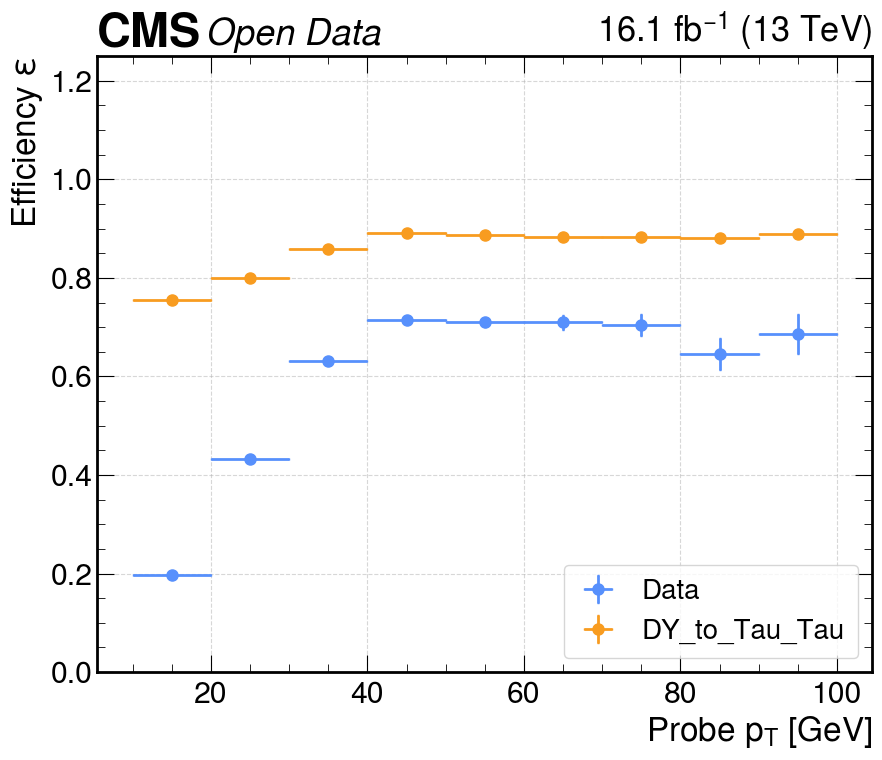

In [41]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import mplhep as hep
import hist

hep.style.use("CMS")

fig, ax = plt.subplots(figsize=(10, 8))

# output_filename = "efficiency_results.root"
# root_file = uproot.recreate(output_filename)

for label, hists_dict in final_hists.items():
    
    axis = hist.axis.Variable(PT_BINS, name="pt", label=r"Probe $p_T$ [GeV]")
    
    h_pass = hist.Hist(axis)
    h_total = hist.Hist(axis)
    
    h_pass[:] = hists_dict["pass"]
    h_total[:] = hists_dict["total"]
    
    num = h_pass.values()
    den = h_total.values()
    
    eff = np.divide(num, den, out=np.zeros_like(num), where=den!=0)
    
    err = np.sqrt(eff * (1 - eff) / den, out=np.zeros_like(eff), where=den!=0)
    
    centers = axis.centers
    edges = axis.edges
    width = (edges[1:] - edges[:-1]) / 2

    ax.errorbar(
        centers,
        eff,
        yerr=err,
        xerr=width,
        fmt='o',
        capsize=1,  
        label=label,
        markersize=8,
        linewidth=2
    )
    
    safe_label = label.replace(" ", "_")
    # root_file[f"{safe_label}_pass"] = h_pass
    # root_file[f"{safe_label}_total"] = h_total
    


hep.cms.label(
    "Open Data", 
    data=True, 
    lumi=16.1, 
    year=2016, 
    ax=ax, 
    rlabel="16.1 fb$^{-1}$ (13 TeV)"
)

# 4. Final Formatting
ax.set_ylabel("Efficiency $\epsilon$", fontsize=24)
ax.set_xlabel(r"Probe $p_T$ [GeV]", fontsize=24)
ax.set_ylim(0.0, 1.25) # Give space for the legend
ax.legend(loc="lower right", fontsize=20, frameon=True)
ax.grid(True, linestyle="--", alpha=0.5)

# Close ROOT file
# root_file.close()
# print(f"Histograms saved to {output_filename}")

plt.show()